In [38]:
using JLD2, FileIO, FITSIO, DataFrames, CSV, PyPlot, PyCall
LogNorm = pyimport("matplotlib.colors").LogNorm
include("get_lamost_spectra.jl")
;

### load battery

In [10]:
lamost = CSV.read("../cats/LAMOST-dr4v2-stellar.csv");
tenth = Set(CSV.read("one_tenth_of_LAMOST.csv").obsid);
battery = DataFrame()
FITS("../cats/the-battery-stars.rc.fits") do hdus
    battery.fn = read(hdus[2], "lamost_id")
    battery.ra = read(hdus[2], "ra")
    battery.dec = read(hdus[2], "dec")
end
;
battery = join(battery, lamost, on=[:ra, :dec]);
battery = Set(battery.obsid) ∩ tenth;
length(battery)

259

In [29]:
FITS("../cats/LAMOST-dr2-stellar.fits.gz") do hdus
    dr2 = Set(read(hdus[2], "obsid"))
end
;

Set(Int32[173810041, 220710081, 46206119, 242614048, 180406189, 170502231, 16016177, 130405232, 39615023, 158712086  …  123116196, 169501025, 192716068, 151801059, 213015013, 174301185, 234002232, 194403107, 200305180, 101608075, 16315220])

### load test results (TODO: fix errors on k8t1000)

In [157]:
iis = 1:20

dfs = map(iis) do i
    df = load("topsnr_test/$i.jld2")["out"]
end
sdf = vcat(dfs...);

dfs = map(iis) do i
    df = load("random_test/$i.jld2")["out"]
end
rdf = vcat(dfs...);

dfs = map(iis) do i
    df = load("distributed_test/$i.jld2")["out"]
end
ddf = vcat(dfs...)

dfs = Dict("s"=>sdf, "r"=>rdf, "d"=>ddf);

for k in ["s", "r", "d"]
    dfs[k] = join(dfs[k], lamost[:, [:obsid, :teff, :feh, :logg, :snrz]], on=:obsid, kind=:left)
end

In [24]:
#iis = [i for i in 1:20 if i != 3]
#
#dfs = map(iis) do i
#    df = load("k4_t1000_test/$i.jld2")["out"]
#end
#k4df = vcat(dfs...);
#
#dfs = map(iis) do i
#    df = load("k8_t1000_test/$i.jld2")["out"]
#end
#k8df = vcat(dfs...);
#
#dfs = map(iis) do i
#    df = load("k16_t1000_test/$i.jld2")["out"]
#end
#k16df = vcat(dfs...)
#
#dfs = Dict(4=>k4df, 8=>k8df, 16=>k16df);
#
#for k in [4, 8, 16]
#    dfs[k] = join(dfs[k], lamost[:, [:obsid, :lmjd, :teff, :feh, :logg, :snrz]], on=:obsid, kind=:left)
#end

### define masked region

In [44]:
include("air_vacuum.jl")

wl_grid = load("wl_grid.jld2")["wl_grid"]
Δλ = 7                                                                                    
li_air = 6707.85
li_vac = air_to_vac(li_air)
line_mask = li_air - Δλ .< wl_grid .< li_air + Δλ
;

### model comparison

In [158]:
ϕ(x, μ, σ) = exp(-1/2 * (x-μ)^2/σ^2) #gaussian kernel
n = sum(line_mask)
M = zeros(2 + n, n)
M[1, :] = ϕ.(wl_grid[line_mask], li_vac, li_air/3600.)
M[1, :] ./= sqrt(sum(M[1, :].^2))
M[2, :] .= sqrt(1/n)
for i in 3:(2+n)
    M[i, i-2] = 1.
end

@time for (k, df) in dfs
    D = reduce(hcat, df.diff) 
    E = reduce(hcat, df.err).^2
    l1 = M.^2 * (1 ./ E)
    l2 = M * (D./E)
    loss = @. -l2^2 / l1
    df[!, :loss] = collect(eachcol(loss))
    df[!, :isline] = argmin.(df.loss) .== 1
    df.amplitude = first.(collect(eachcol(l2 ./ l1)))
    
    df.delta_chi2 = map(eachrow(df)) do row
        row.isline ? minimum(row.loss[2:end]) - row.loss[1] : NaN
    end
    
    df.inbat = map(eachrow(df)) do row
        row.obsid in battery
    end
    
    df.oldcat = map(eachrow(df)) do row
        (row.obsid in dr2) && (row.logg .< 3)
    end
end

 51.186047 seconds (23.74 M allocations: 1.296 GiB, 88.14% gc time)


In [159]:
for (k, df) in dfs
    println("$k")
    
    cut = 50#quantile(df[df.isline .& (df.amplitude .> 0), :delta_chi2], 0.98)
    println("using Δχ^2 > $cut")
    df.match = df.isline .& (df.amplitude .> 0) .& (df.delta_chi2 .> cut)
    println(sum(df.match))
    
    println("fraction of all spectra that match a line model: ", sum(df.match) / size(df, 1))
    println("fraction of battery stars that match a line model: ", sum(df.match .& df.inbat) / sum(df.inbat))
    println("$(sum(df.match .& df.inbat)) match &  battery")
    println("$(sum(df.match .& (.! df.inbat))) match & ¬battery")
    println("$(sum((.! df.match) .& df.inbat)) ¬match & battery")
    println("$(sum((.! df.match) .& (.! df.inbat))) ¬match & ¬battery")
    
    println("flagged $(sum(df[df.oldcat, :match])) including $(sum(df[df.oldcat, :match] .& df[df.oldcat, :inbat])) of $(sum(df[df.oldcat, :inbat])) in battery for DR2 giants")
    println()
    
end

println()
intersection = intersect([Set(df.obsid[df.match]) for (k, df) in dfs]...)
println("$(length(intersection)) stars in the intersection of all 3")

k = r
using Δχ^2 > 50
1857
fraction of all spectra that match a line model: 0.0040926431598643275
fraction of battery stars that match a line model: 0.5735294117647058
156 match &  battery
1701 match & ¬battery
116 ¬match & battery
451768 ¬match & ¬battery
flagged 179 including 140 of 241 in battery for DR2 giants

k = s
using Δχ^2 > 50
676
fraction of all spectra that match a line model: 0.0014898367130146933
fraction of battery stars that match a line model: 0.5330882352941176
145 match &  battery
531 match & ¬battery
127 ¬match & battery
452938 ¬match & ¬battery
flagged 192 including 133 of 241 in battery for DR2 giants

k = d
using Δχ^2 > 50
658
fraction of all spectra that match a line model: 0.0014502879637119438
fraction of battery stars that match a line model: 0.5588235294117647
152 match &  battery
506 match & ¬battery
120 ¬match & battery
452925 ¬match & ¬battery
flagged 169 including 138 of 241 in battery for DR2 giants


420 stars in the intersection of all 3


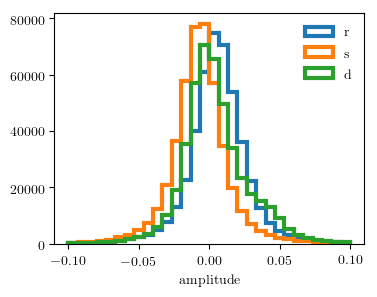

PyObject Text(0.5, 23.999999999999993, 'amplitude')

In [161]:
figure(figsize=(4,3))
for (m, df) in dfs
    plt.hist(df.amplitude, label=m, range=(-.1,.1), bins=30, histtype="step", lw=3)
end
legend()
xlabel("amplitude")

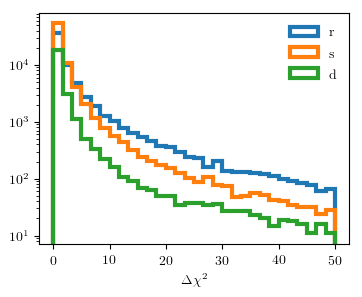

PyObject Text(0.5, 23.999999999999993, '$\\Delta \\chi^2$')

In [162]:
figure(figsize=(4,3))
for (m, df) in dfs
    plt.hist(df.delta_chi2, label=m, range=(0,50), bins=30, histtype="step", lw=3)
end
legend()
plt.yscale("log")
xlabel(L"\Delta \chi^2")

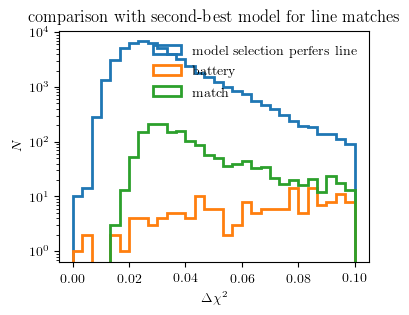

PyObject Text(0.5, 1.0, 'comparison with second-best model for line matches')

In [163]:
figure(figsize=(4,3))
df = dfs["r"]
plt.hist(df[df.isline, :amplitude], bins=30, range=(0, 0.1), histtype="step", label="model selection perfers line", lw=2)
plt.hist(df[df.inbat, :amplitude], bins=30, range=(0, 0.1), histtype="step", label="battery", lw=2)
plt.hist(df[df.match, :amplitude], bins=30, range=(0, 0.1), histtype="step", label="match", lw=2)
legend()
plt.yscale("log")
ylabel(L"N")
xlabel(L"\Delta \chi^2")
title("comparison with second-best model for line matches")

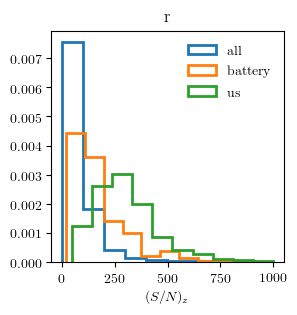

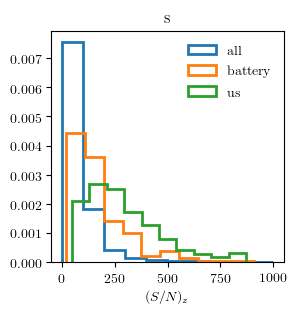

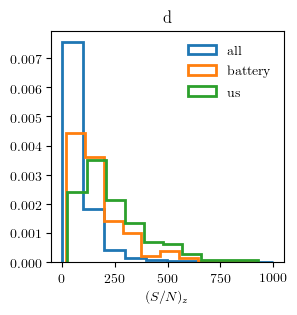

In [164]:
include("human_readable_names.jl")
for (m, df) in dfs
    figure(figsize=(3,3))
    title(m)
    col=:snrz
    plt.hist(df[!, col], histtype="step", lw=2, normed=true, label="all")
    plt.hist(df[df.inbat, col], histtype="step", lw=2, normed=true, label="battery")
    plt.hist(df[df.match, col], histtype="step", lw=2, normed=true, label="us")
    legend()
    xlabel(hrname(col))
end

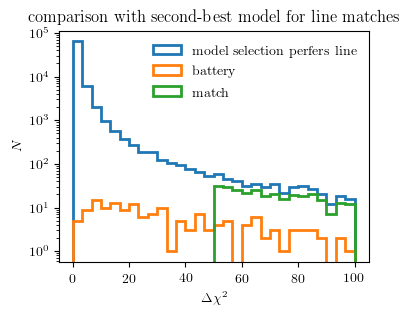

PyObject Text(0.5, 1.0, 'comparison with second-best model for line matches')

In [167]:
figure(figsize=(4,3))
df = dfs["s"]
plt.hist(df[df.isline, :delta_chi2], bins=30, range=(0, 100), histtype="step", label="model selection perfers line", lw=2)
plt.hist(df[df.inbat, :delta_chi2], bins=30, range=(0, 100), histtype="step", label="battery", lw=2)
plt.hist(df[df.match, :delta_chi2], bins=30, range=(0, 100), histtype="step", label="match", lw=2)
legend()
plt.yscale("log")
ylabel(L"N")
xlabel(L"\Delta \chi^2")
title("comparison with second-best model for line matches")

# science

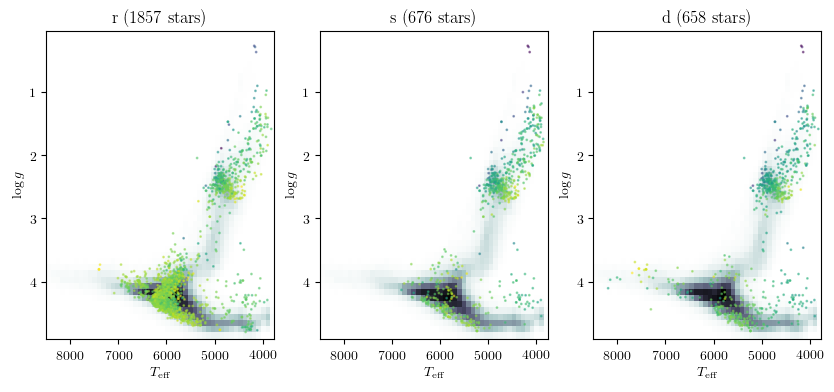

In [175]:
axs = subplots(1, 3, figsize=(10, 4))[2]
for (i, (k, df)) in enumerate(dfs)
    sca(axs[i])
    title("$k ($(sum(df.match)) stars)")
    mask = df.inbat .& (.! df.match)
    plt.hist2d(df.teff, df.logg, cmap="bone_r", bins=50, zorder=-1)#, norm=LogNorm())
    scatter(df[df.match, :teff], df[df.match, :logg], s=1, label=string(k), c=df[df.match, :feh], alpha=0.5, cmap="viridis")
    gca().invert_yaxis()
    gca().invert_xaxis()
    xlabel(L"T_\mathrm{eff}")
    ylabel(L"\log g")
end


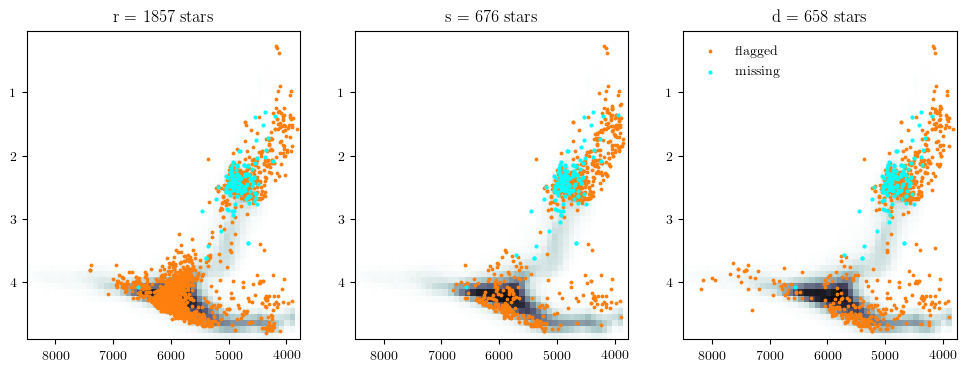

PyObject <matplotlib.legend.Legend object at 0x1a4309c88>

In [174]:
axs = subplots(1, 3, figsize=(12, 4))[2]
for (i, (k, df)) in enumerate(dfs)
    sca(axs[i])
    title("$k  = $(sum(df.match)) stars")
    plt.hist2d(df.teff, df.logg, cmap="bone_r", bins=50, zorder=-1)#, norm=LogNorm())
    scatter(df[df.match, :teff], df[df.match, :logg], s=3, c="C1", label="flagged")
    mask = df.inbat .& (.! df.match)
    scatter(df[mask, :teff], df[mask, :logg], s=4, c="cyan", label="missing")
    #xlim(3600, 6000)
    #ylim(0,4)
    gca().invert_yaxis()
    gca().invert_xaxis()
end
legend()


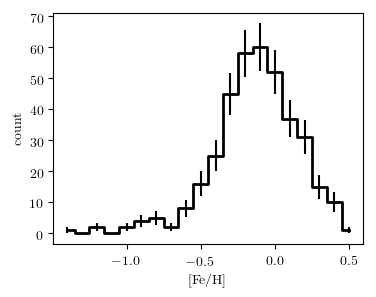

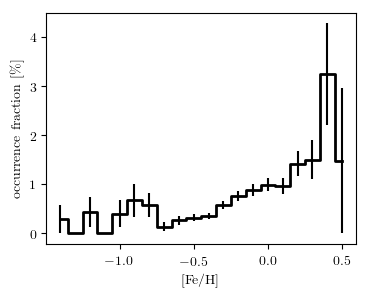

PyObject Text(0.5, 23.999999999999993, '[Fe/H]')

In [170]:
using StatsBase
df = dfs["d"]
fehbins=-1.5:0.1:0.5

gmatch = df.match .& (df.logg .< 3)

h = fit(Histogram, df[gmatch, :feh], fehbins)
h2 = fit(Histogram, df[df.logg .< 3, :feh], fehbins)
midpoints = h.edges[1][1:end-1] + diff(h.edges[1])

figure(figsize=(4,3))
plt.errorbar(midpoints, h.weights, sqrt.(h.weights), ls="", c="k")
plt.step(midpoints, h.weights, where="mid", lw=2, c="k")
ylabel("count")
xlabel("[Fe/H]")

figure(figsize=(4,3))
plt.errorbar(midpoints, h.weights./h2.weights * 100, 
    sqrt.(h.weights .+ h.weights.^2 ./ h2.weights)./h2.weights * 100, ls="", c="k")
plt.step(midpoints, h.weights./h2.weights * 100 , lw=2, where="mid", c="k")
ylabel("occurrence fraction [\\%]")
xlabel("[Fe/H]")

# look at spectra

In [149]:
function plot_spectrum(row)
    
    print("obsid: ", row.obsid)
    println(" ... in the battery? $(row.obsid in battery)")
    
    download_lamost_spectra([row.obsid], verbose=false)
    wl, flux, ivar = load_lamost_spectrum(row.obsid)
    download_lamost_spectra(row.neighbors, verbose=false)
    F = hcat((n->load_lamost_spectrum(n)[2]).(row.neighbors)...)
    
    figure(figsize=(3,3))
    ylabel("residuals")
    xlabel(L"$\lambda$ [\AA]")
    errorbar(wl_grid[line_mask], row.diff, yerr=row.err, label="data")
    errorbar(wl_grid[line_mask], M[1, :]*row.amplitude, label="best fit line model")
    legend()
    
    figure(figsize=(12, 3))
    ylabel(L"F/F_\mathrm{cont}")
    xlabel(L"$\lambda$ [\AA]")
    plt.plot(wl, flux, label="data")
    axvspan(li_air - Δλ, li_air + Δλ, alpha=0.2, color="gray")
    plt.plot(wl, F*row.weights, label="synthetic")
    legend()
    
    figure(figsize=(12, 3))
    ylabel(L"F/F_\mathrm{cont}")
    xlabel(L"$\lambda$ [\AA]")
    errorbar(wl, flux, yerr=ivar.^(-1/2), label="data");
    axvspan(li_air - Δλ, li_air + Δλ, alpha=0.2, color="gray")
    plt.plot(wl, F*row.weights, label="synthetic")
    legend()
    xlim(6660, 6750)
    ylim(0.9, 1.1)
    
    ;
end

plot_spectrum (generic function with 1 method)

In [ ]:
dfs[]

[-128.576, -44.9422, -10.9217, -0.556454, -9.31982, -14.1225, -47.3788, -34.7316, -63.8308, -11.0007, -0.295296]
64.74515500484686
obsid: 181203120 ... in the battery? false
of 1 spectra, 1 need to be downloaded
of 6 spectra, 4 need to be downloaded
distance to synthetic spectrum:-213.8285
[-19.6168, -3.21804, -12.198, -9.44439, -17.4546, -13.1718, -6.93078, -39.4545, -2.72339, -169.151, -137.545]
NaN
obsid: 181203120 ... in the battery? false
of 1 spectra, 0 need to be downloaded
of 6 spectra, 3 need to be downloaded
distance to synthetic spectrum:-1860.2983
[-2.52275, -4.39773, -1.49362, -1.16339, -0.194182, -0.349952, -0.00539142, -2.88051, -0.506829, -0.291603, -1.35121]
NaN
obsid: 439501146 ... in the battery? false
of 1 spectra, 1 need to be downloaded
of 6 spectra, 0 need to be downloaded


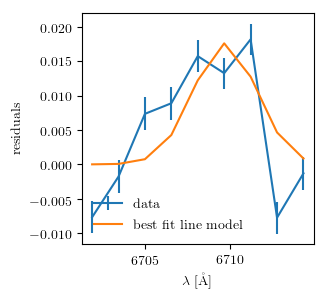

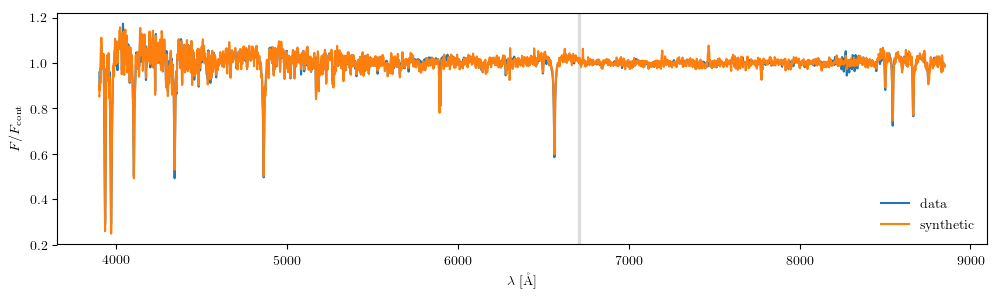

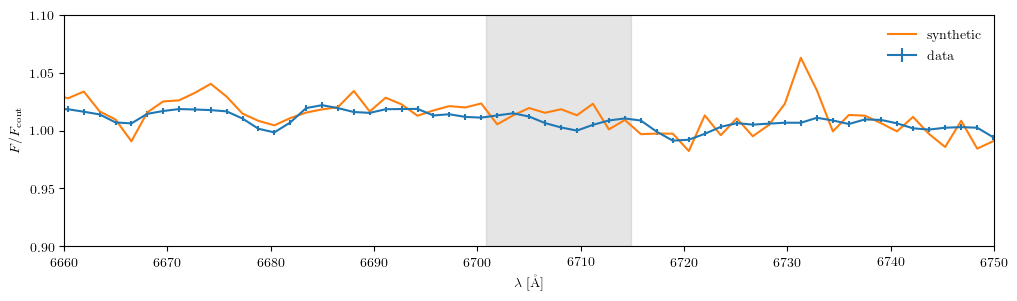

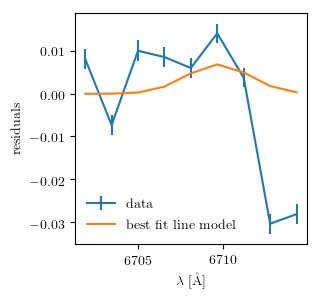

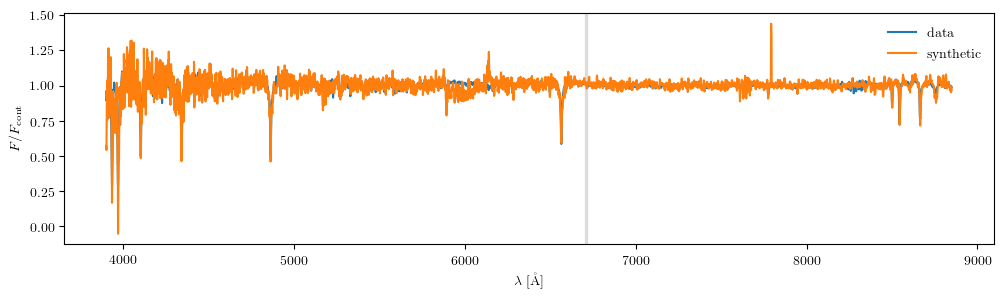

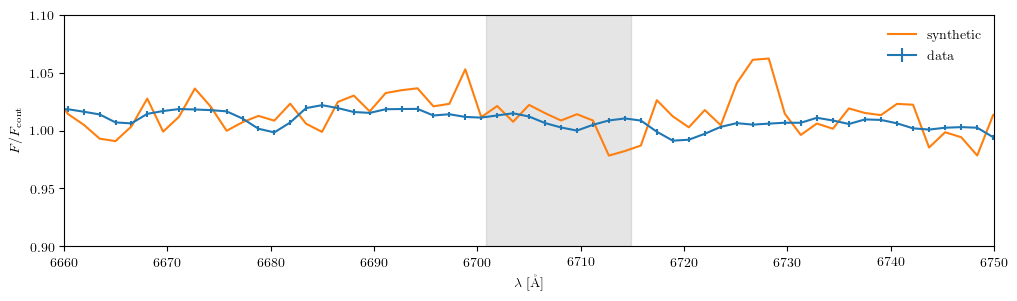

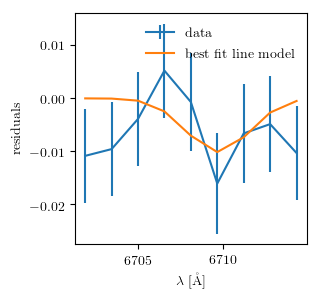

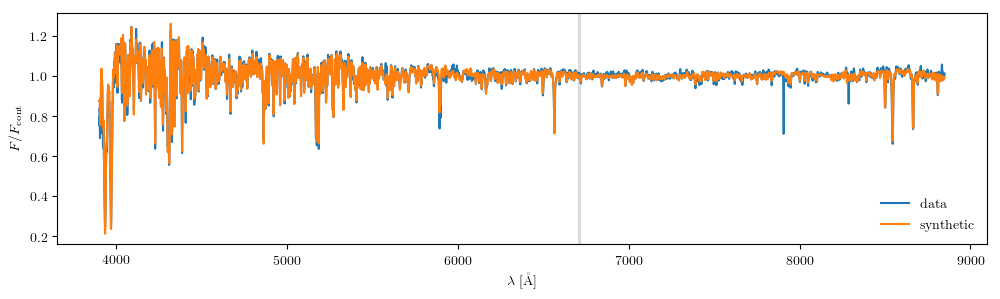

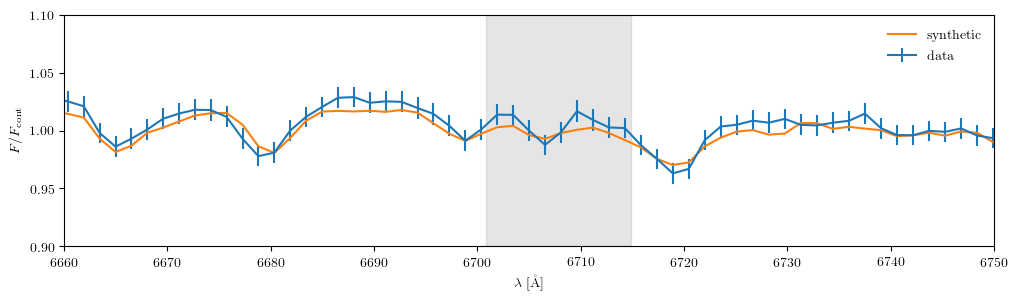

distance to synthetic spectrum:21.247528


(0.9, 1.1)

In [187]:
ind = Set(dfs["d"].obsid[dfs["d"].match])
i = findall(dfs["r"].match .& (.! [o in ind for o in dfs["r"].obsid]))[100]
df = dfs["r"]
println(df[i, :loss])
println(df[i, :delta_chi2])
plot_spectrum(df[i, :])

i = findfirst(dfs["d"].obsid .== dfs["r"].obsid[i])
df = dfs["d"]
println(df[i, :loss])
println(df[i, :delta_chi2])
plot_spectrum(df[i, :])

i = findfirst(dfs["s"].obsid .== dfs["r"].obsid[i])
df = dfs["s"]
println(df[i, :loss])
println(df[i, :delta_chi2])
plot_spectrum(df[i, :])

# old stuff 

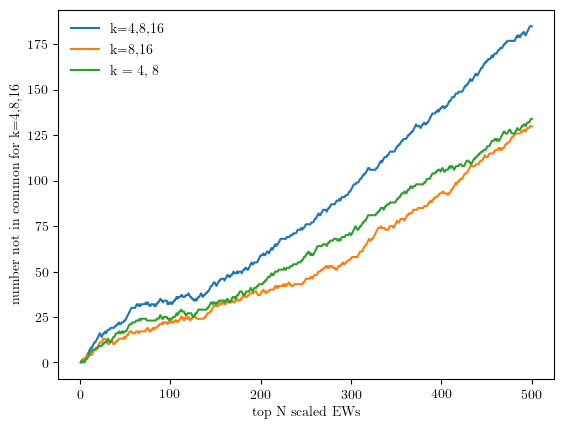

PyObject Text(22.299550986642984, 0.5, 'number not in common for k=4,8,16')

In [36]:
sk4df = sort(k4df, :SEW, rev=true)
sk8df = sort(k8df, :SEW, rev=true)
sk16df = sort(k16df, :SEW, rev=true)
sk4df = sk4df[.! isnan.(sk4df.SEW), :]
sk8df = sk8df[.! isnan.(sk8df.SEW), :]
sk16df = sk16df[.! isnan.(sk16df.SEW), :]


N = 500
incommon(xs) = length(intersect((Set.(xs))...))
c = map(1:N) do i
    i - incommon([df.obsid[1:i] for df in [sk4df, sk8df, sk16df]])
end
plot(1:N, c, label="k=4,8,16")
c = map(1:N) do i
    i - incommon([df.obsid[1:i] for df in [sk8df, sk16df]])
end
plot(1:N, c, label="k=8,16")
c = map(1:N) do i
    i - incommon([df.obsid[1:i] for df in [sk4df, sk8df]])
end
plot(1:N, c, label="k = 4, 8")
legend()
xlabel("top N scaled EWs")
ylabel("number not in common for k=4,8,16")

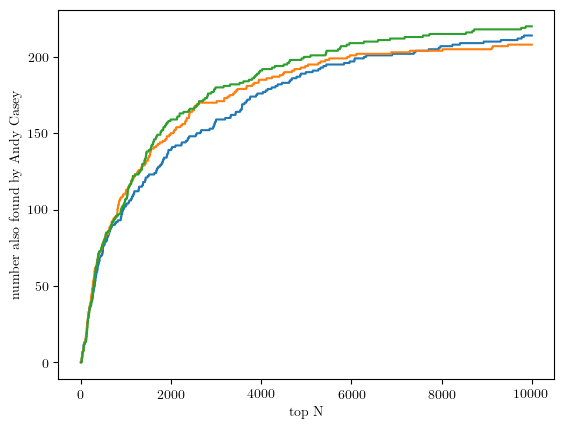

PyObject Text(22.299550986642984, 0.5, 'number also found by Andy Casey')

In [37]:
N = 10000
function f(df)
    map(1:N) do i
        length(intersect(Set(df.obsid[1:i]), battery))
    end
end
plot(1:N, f(sk4df))
plot(1:N, f(sk8df))
plot(1:N, f(sk16df))
xlabel("top N")
ylabel("number also found by Andy Casey")

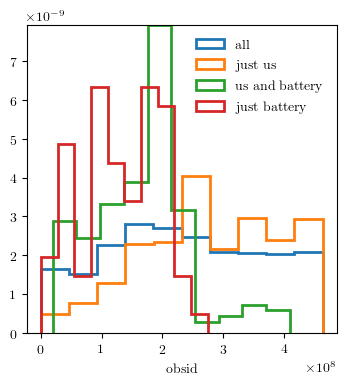

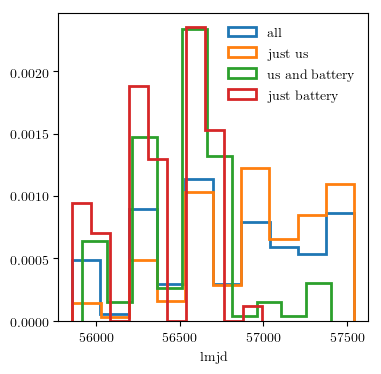

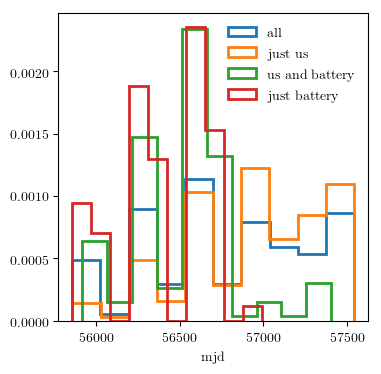

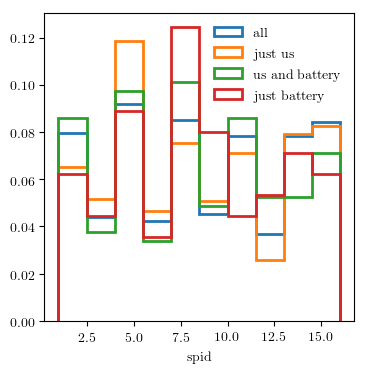

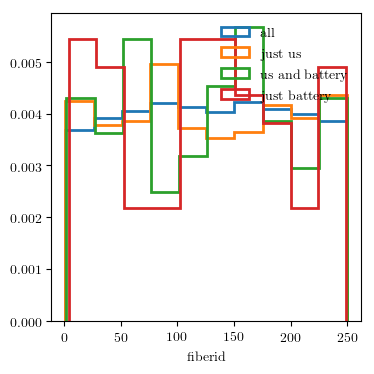

Figure(PyObject <Figure size 400x400 with 1 Axes>)

Figure(PyObject <Figure size 400x400 with 1 Axes>)

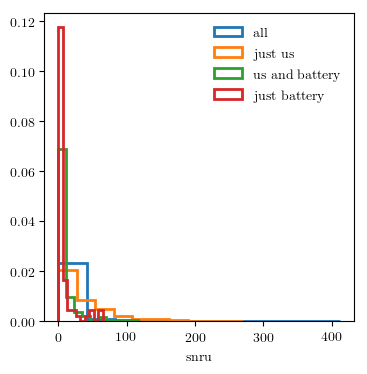

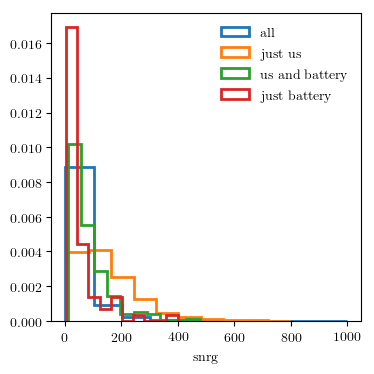

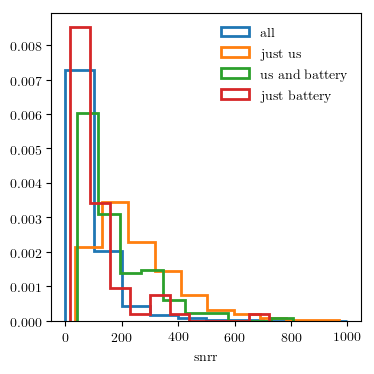

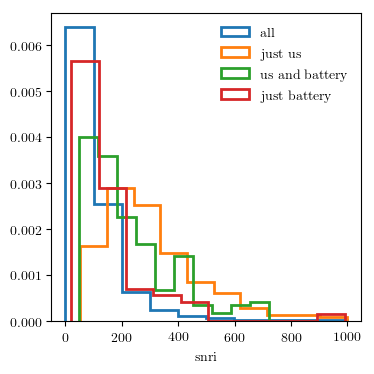

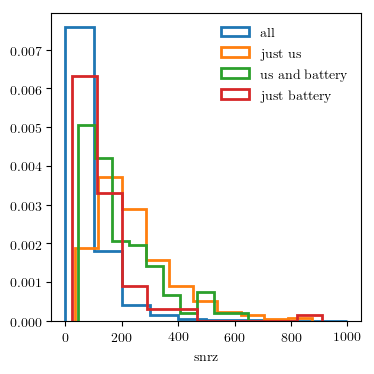

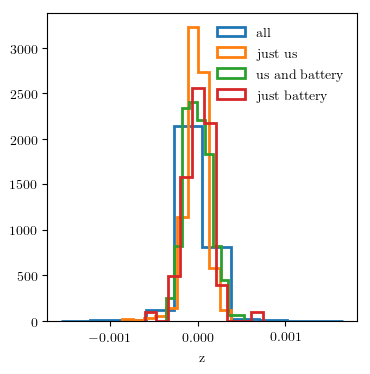

Figure(PyObject <Figure size 400x400 with 1 Axes>)

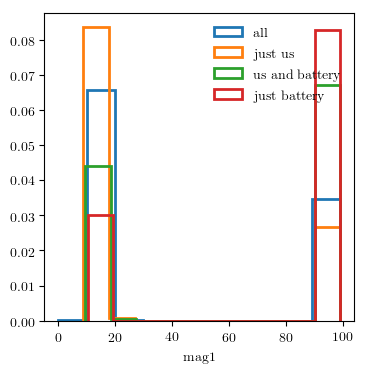

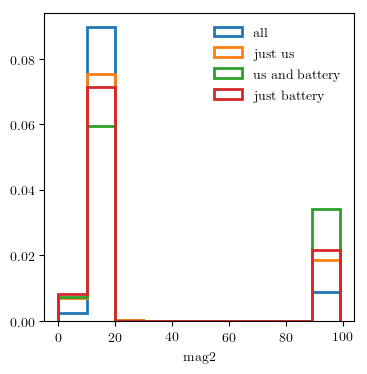

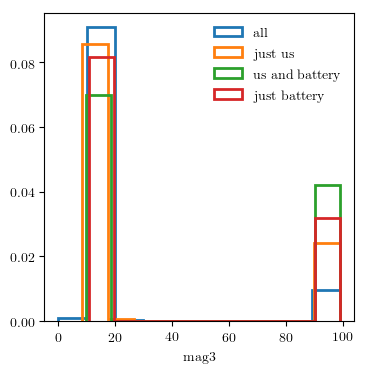

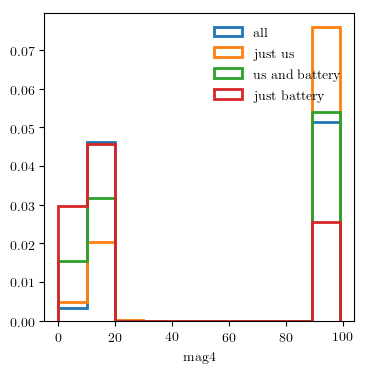

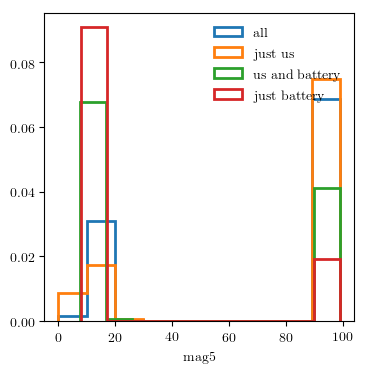

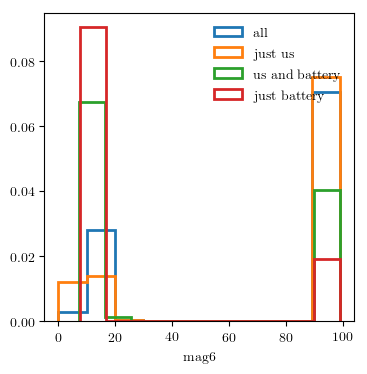

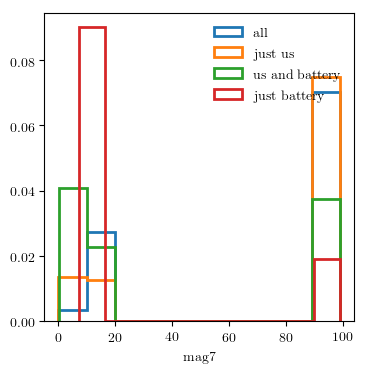

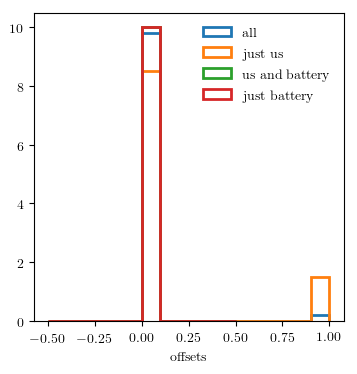

Figure(PyObject <Figure size 400x400 with 1 Axes>)

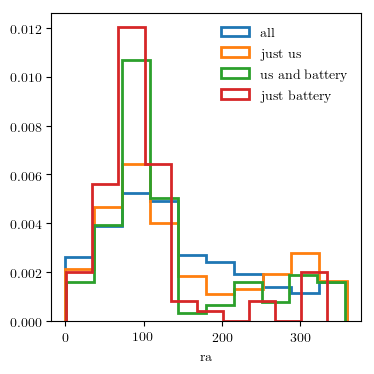

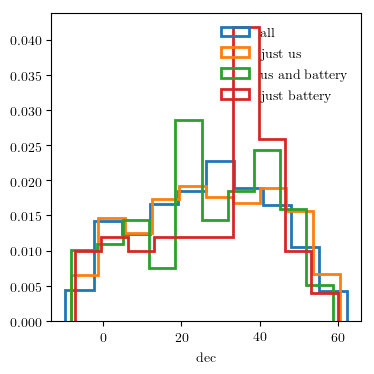

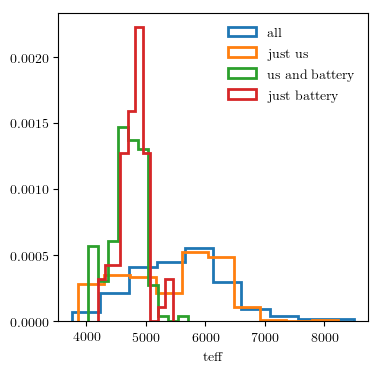

Figure(PyObject <Figure size 400x400 with 1 Axes>)

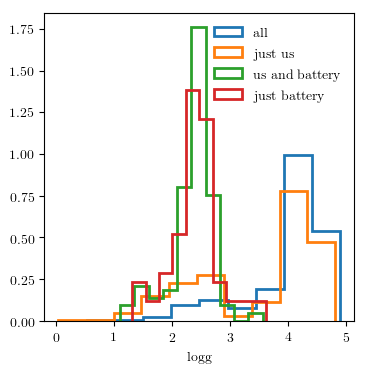

Figure(PyObject <Figure size 400x400 with 1 Axes>)

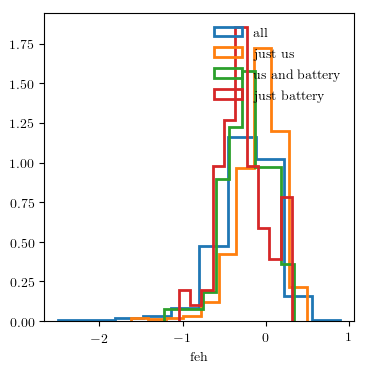

Figure(PyObject <Figure size 400x400 with 1 Axes>)

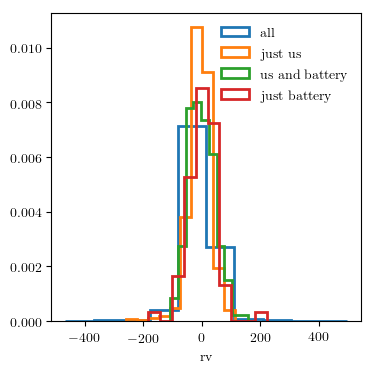

Figure(PyObject <Figure size 400x400 with 1 Axes>)

In [90]:
for a in names(lamost)
    if typeof(lamost[1, a]) <: Number
        figure(figsize=(4,4))
        plt.hist(df[! , a], normed=true, histtype="step", label="all", lw=2)
        plt.hist(df[df.match .& (.! df.inbat), a], normed=true, histtype="step", label="just us", lw=2)
        plt.hist(df[df.match .& (df.inbat), a], normed=true, histtype="step", label="us and battery", lw=2)
        plt.hist(df[(.! df.match) .& (df.inbat), a], normed=true, histtype="step", label="just battery", lw=2)
        legend()
        xlabel(String(a))
    end
end